## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

data = np.load("pcd_data/w1280_h720/3.npy", allow_pickle=True)
data = data[None][0]
pc = data["pc"]
rgb = data["img_feat"]

# Rendering

### Simple Example - Perspective Camera

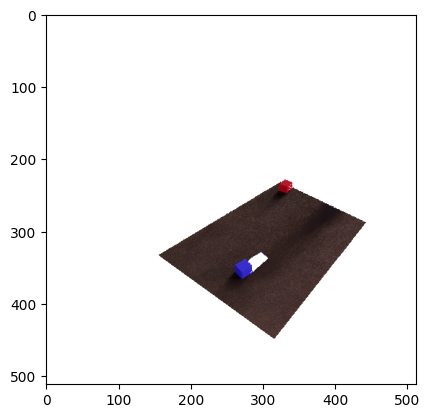

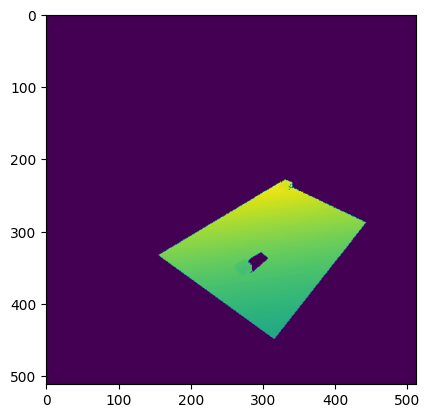

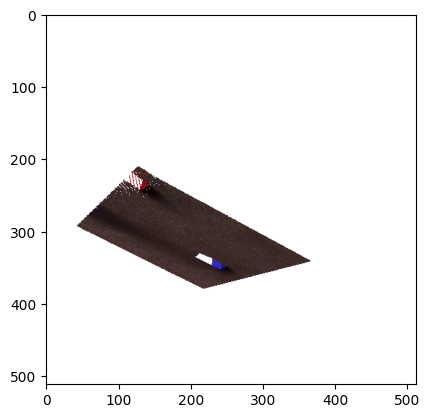

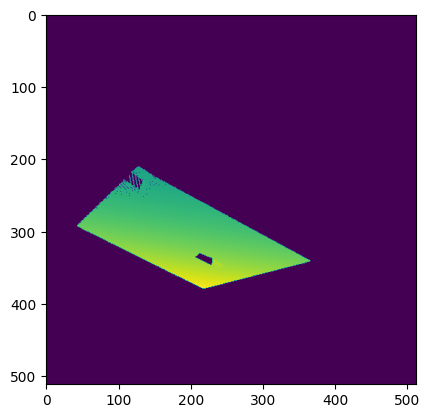

In [2]:
# Make the renderer
from point_renderer.renderer import PointRenderer, PerspectiveCameras, OrthographicCameras
renderer = PointRenderer(device="cuda", perf_timer=False)

# Define a batch of cameras from lookats
img_size = (512, 512)
cameras = PerspectiveCameras.from_lookat(
    eyes=[[1.5, 1.5, 1.5],[-1.5, -1.5, -1.5]],
    ats=[[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]],
    ups=[[0, 0, 1], [0, 0, 1]],
    hfov=70,
    img_size=img_size,
    device="cuda"
)

# Render the pointcloud from the given cameras
images, depths = renderer.render_batch(pc, rgb, cameras, img_size, 
                                       default_color=1.0, 
                                       splat_radius=0.005,
                                       aa_factor=1
                                      )

# Show the results
plt.imshow(images[0].detach().cpu().numpy()); plt.show()
plt.imshow(depths[0].detach().cpu().numpy()); plt.show()
plt.imshow(images[1].detach().cpu().numpy()); plt.show()
plt.imshow(depths[1].detach().cpu().numpy()); plt.show()

### Simple Example - Box Renderer

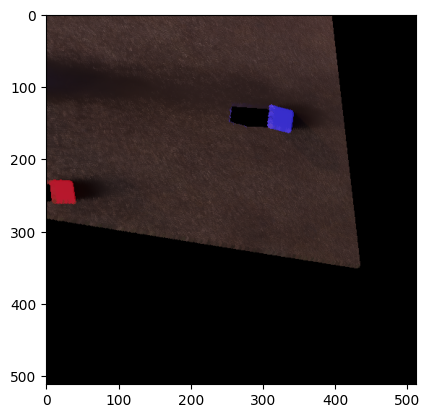

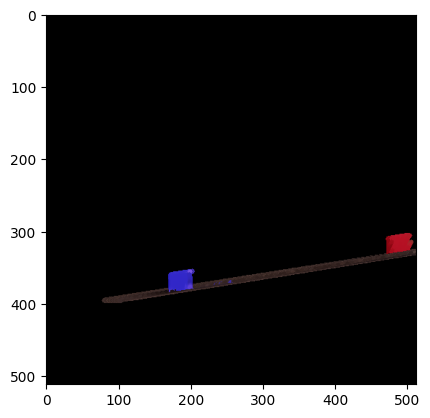

In [10]:
from point_renderer.rvt_renderer import RVTBoxRenderer

box_renderer = RVTBoxRenderer(
    device="cuda:0",
    img_size=(512, 512),
    antialiasing_factor=1,
    with_depth=True
)

img = box_renderer(pc, rgb)

for i in range(len(images)):
    plt.imshow(img[i][:, :, :3].detach().cpu().numpy()); plt.show()

### Simple Example - Orthographic Camera

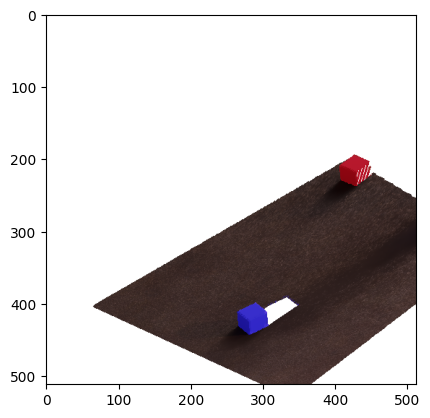

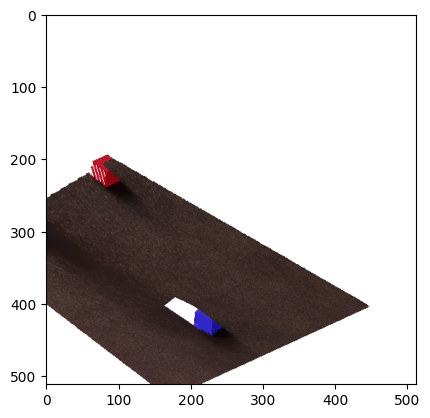

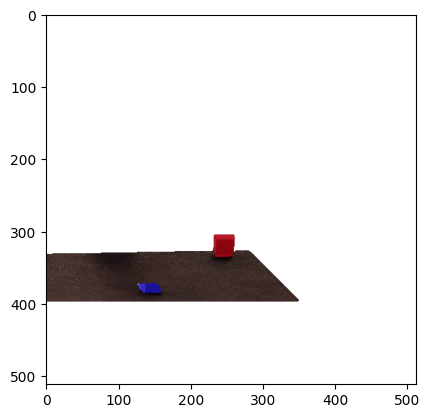

In [4]:
# Make the renderer
from point_renderer.renderer import PointRenderer, PerspectiveCameras, OrthographicCameras
renderer = PointRenderer(device="cuda", perf_timer=False)

# Define a batch of orthographic cameras
img_size = (512, 512)

cameras = OrthographicCameras.from_lookat(
    eyes=[[1.5, 1.5, 1.5],[-1.5, -1.5, -1.5], [-2.0, 0.0, 0.0]],
    ats=[[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]],
    ups=[[0, 0, 1], [0, 0, 1], [0, 0, 1]],
    img_sizes_w=[2.0, 2.0],
    img_size_px=img_size,
    device="cuda"
)

# Render the pointcloud from the given cameras
images, depths = renderer.render_batch(pc, rgb, cameras, img_size, 
                                       default_color=1.0, 
                                       splat_radius=0.005,
                                       aa_factor=1
                                      )

for i in range(len(cameras)):
    print("")
    plt.imshow(images[i].detach().cpu().numpy()); plt.show()

### Test rendering xyz and RGB together

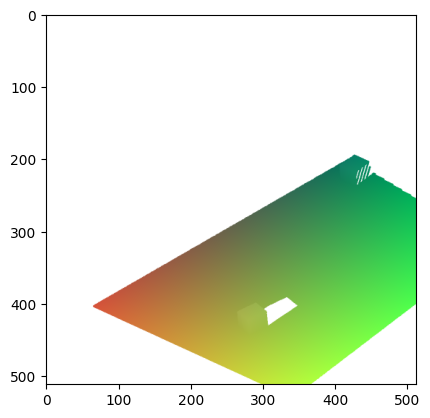

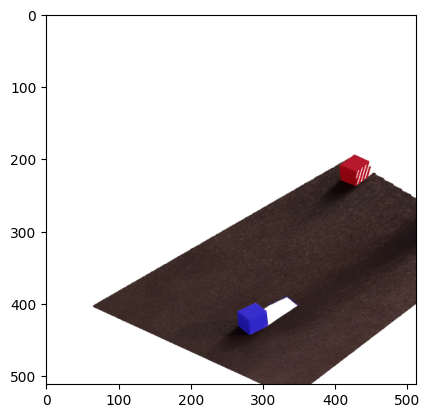

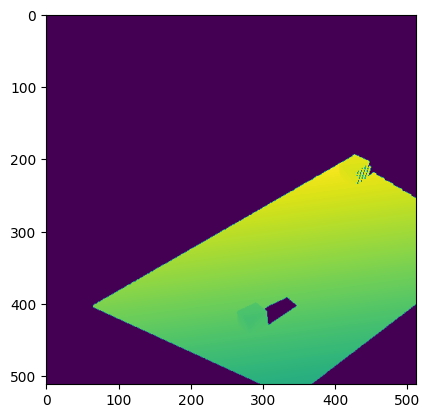

In [9]:
import torch
xyzrgb = torch.cat([pc, rgb], dim=1)
image, depth = renderer.render_batch(pc, xyzrgb.contiguous(), cameras, img_size, 
                                     default_depth=0.0, default_color=1.0,
                                     splat_radius=0.005,
                                     aa_factor=2)

plt.imshow((image[0, :, :, :3] / 2 + 0.5).detach().cpu().numpy()); plt.show()
plt.imshow((image[0, :, :, 3:]).detach().cpu().numpy()); plt.show()
plt.imshow(depth[0].detach().cpu().numpy()); plt.show()

#imageio.imwrite("image_xyz.png", (image[0, :, :, :3] / 2 + 0.5).detach().cpu().numpy())
#imageio.imwrite("image_rgb.png", (image[0, :, :, 3:]).detach().cpu().numpy())
#imageio.imwrite("image_depth.png", ((depth[0] - 1.5) / (depth[0].max() - 1.5)).clamp(0,1).detach().cpu().numpy())

# Benchmarking

### Render time vs feature size

In [4]:
# Make a new renderer with a perf timer
renderer = PointRenderer(device="cuda", perf_timer=True)

# Define N camera poses, all with the same intrinsics
img_size = (512, 512)
cam_positions = [
    [1.5, 1.5, 1.5],
    [-1.5, -1.5, -1.5],
    [1.5, -1.5, 1.5],
    [-1.5, 1.5, 0.0],
    [1.5, -1.5, 0.0],
    [-1.5, -1.5, 1.5]
]
cam_lookats = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
]

K = renderer.get_camera_intrinsics(hfov=70, img_size=img_size)
Ts = renderer.get_batch_of_camera_poses(cam_positions, cam_lookats)

# Benchmarking performance w.r.t. feature size
feature_sizes = [3, 6, 12, 24, 48, 96]

gpu_times = []
cpu_times = []

for feat_dim in feature_sizes:
    point_features = torch.rand([pc.shape[0], feat_dim], device="cuda")

    renderer.render_batch(pc, point_features, Ts, K, img_size)
    renderer.timer.init()
    
    for t in range(10):
        image, depth = renderer.render_batch(pc, point_features, Ts, K, img_size)

    cpu_time = renderer.timer.get_avg_cpu_time("render_setup") + renderer.timer.get_avg_cpu_time("render")
    gpu_time = renderer.timer.get_avg_gpu_time("render_setup") + renderer.timer.get_avg_gpu_time("render")
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

print("Feature sizes")
for f in feature_sizes:
    print(f)
print("GPU Times\n")
for f, g in zip(feature_sizes, gpu_times):
    print(g)
print("\nCPU Times\n")
for f, c in zip(feature_sizes, cpu_times):
    print(c)
print("GPU Time per camera\n")
for f, g in zip(feature_sizes, gpu_times):
    print(g / Ts.shape[0])
print("\nCPU Time per camera\n")
for f, c in zip(feature_sizes, cpu_times):
    print(c / Ts.shape[0])

CPU Checkpoint render_setup: 2.729e-03s (Avg: 2.729e-03s)
GPU Checkpoint render_setup: 2.718e-03s (Avg: 2.718e-03s)
CPU Checkpoint render: 3.314e-04s (Avg: 3.314e-04s)
GPU Checkpoint render: 3.379e-04s (Avg: 3.379e-04s)
CPU Checkpoint antialiasing: 1.878e-04s (Avg: 1.878e-04s)
GPU Checkpoint antialiasing: 1.905e-04s (Avg: 1.905e-04s)
CPU Checkpoint render_setup: 9.645e-04s (Avg: 9.645e-04s)
GPU Checkpoint render_setup: 9.830e-04s (Avg: 9.830e-04s)
CPU Checkpoint render: 2.963e-04s (Avg: 2.963e-04s)
GPU Checkpoint render: 3.011e-04s (Avg: 3.011e-04s)
CPU Checkpoint antialiasing: 7.105e-05s (Avg: 7.105e-05s)
GPU Checkpoint antialiasing: 7.270e-05s (Avg: 7.270e-05s)
CPU Checkpoint render_setup: 9.218e-04s (Avg: 9.432e-04s)
GPU Checkpoint render_setup: 9.339e-04s (Avg: 9.585e-04s)
CPU Checkpoint render: 3.039e-04s (Avg: 3.001e-04s)
GPU Checkpoint render: 3.092e-04s (Avg: 3.052e-04s)
CPU Checkpoint antialiasing: 2.365e-05s (Avg: 4.735e-05s)
GPU Checkpoint antialiasing: 2.355e-05s (Avg: 4.81

CPU Checkpoint render: 1.196e-02s (Avg: 1.152e-02s)
GPU Checkpoint render: 1.182e-02s (Avg: 1.158e-02s)
CPU Checkpoint antialiasing: 3.038e-05s (Avg: 2.506e-05s)
GPU Checkpoint antialiasing: 2.662e-05s (Avg: 2.310e-05s)
CPU Checkpoint render_setup: 1.046e-03s (Avg: 1.024e-03s)
GPU Checkpoint render_setup: 1.367e-03s (Avg: 1.347e-03s)
CPU Checkpoint render: 1.147e-02s (Avg: 1.151e-02s)
GPU Checkpoint render: 1.148e-02s (Avg: 1.157e-02s)
CPU Checkpoint antialiasing: 2.494e-05s (Avg: 2.504e-05s)
GPU Checkpoint antialiasing: 2.458e-05s (Avg: 2.331e-05s)
CPU Checkpoint render_setup: 9.449e-04s (Avg: 1.014e-03s)
GPU Checkpoint render_setup: 1.267e-03s (Avg: 1.337e-03s)
CPU Checkpoint render: 1.181e-02s (Avg: 1.155e-02s)
GPU Checkpoint render: 1.196e-02s (Avg: 1.162e-02s)
CPU Checkpoint antialiasing: 2.506e-05s (Avg: 2.505e-05s)
GPU Checkpoint antialiasing: 2.355e-05s (Avg: 2.334e-05s)
CPU Checkpoint render_setup: 9.111e-04s (Avg: 1.003e-03s)
GPU Checkpoint render_setup: 1.234e-03s (Avg: 1.32

### Render time vs number of cameras

In [5]:
# Benchmarking performance w.r.t. number of cameras
# Define N camera poses, all with the same intrinsics
cam_positions = [
    [1.5, 1.5, 1.5],
    [-1.5, -1.5, -1.5],
    [1.5, -1.5, 1.5],
    [-1.5, 1.5, 0.0],
    [1.5, -1.5, 0.0],
    [-1.5, -1.5, 1.5]
]
cam_lookats = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
]
K = renderer.get_camera_intrinsics(hfov=70, img_size=img_size)
Ts = renderer.get_batch_of_camera_poses(cam_positions * 6, cam_lookats * 6)


num_cameras = [1, 2, 4, 8, 16, 32]

gpu_times = []
cpu_times = []

for num_cam in num_cameras:
    Ts_b = Ts[:num_cam]
    image, depth = renderer.render_batch(pc, rgb, Ts_b, K, img_size)
    renderer.timer.init()
    for t in range(10):
        image, depth = renderer.render_batch(pc, rgb, Ts_b, K, img_size)

    cpu_time = renderer.timer.get_avg_cpu_time("render_setup") + renderer.timer.get_avg_cpu_time("render")
    gpu_time = renderer.timer.get_avg_gpu_time("render_setup") + renderer.timer.get_avg_gpu_time("render")
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

print("Num cameras")
for f in num_cameras:
    print(f)

print("GPU Times\n")
for f, g in zip(num_cameras, gpu_times):
    print(g)

print("\nCPU Times\n")
for f, c in zip(num_cameras, cpu_times):
    print(c)

print("GPU Times per camera\n")
for f, g in zip(num_cameras, gpu_times):
    print(g / f)

print("\nCPU Times per camera\n")
for f, c in zip(num_cameras, cpu_times):
    print(c / f)

CPU Checkpoint render_setup: 7.734e-04s (Avg: 1.013e-03s)
GPU Checkpoint render_setup: 7.690e-04s (Avg: 1.640e-03s)
CPU Checkpoint render: 2.163e-04s (Avg: 2.561e-02s)
GPU Checkpoint render: 2.181e-04s (Avg: 2.565e-02s)
CPU Checkpoint antialiasing: 1.871e-04s (Avg: 4.391e-05s)
GPU Checkpoint antialiasing: 1.905e-04s (Avg: 3.770e-05s)
CPU Checkpoint render_setup: 3.384e-01s (Avg: 3.384e-01s)
GPU Checkpoint render_setup: 3.384e-01s (Avg: 3.384e-01s)
CPU Checkpoint render: 2.973e-04s (Avg: 2.973e-04s)
GPU Checkpoint render: 3.092e-04s (Avg: 3.092e-04s)
CPU Checkpoint antialiasing: 3.142e-04s (Avg: 3.142e-04s)
GPU Checkpoint antialiasing: 4.004e-04s (Avg: 4.004e-04s)
CPU Checkpoint render_setup: 1.555e-03s (Avg: 1.700e-01s)
GPU Checkpoint render_setup: 1.571e-03s (Avg: 1.700e-01s)
CPU Checkpoint render: 4.156e-04s (Avg: 3.564e-04s)
GPU Checkpoint render: 4.311e-04s (Avg: 3.702e-04s)
CPU Checkpoint antialiasing: 6.505e-05s (Avg: 1.896e-04s)
GPU Checkpoint antialiasing: 6.451e-05s (Avg: 2.32

### Render time vs image size at 6 cameras

In [6]:
cam_positions = [
    [1.5, 1.5, 1.5],
    [-1.5, -1.5, -1.5],
    [1.5, -1.5, 1.5],
    [-1.5, 1.5, 0.0],
    [1.5, -1.5, 0.0],
    [-1.5, -1.5, 1.5]
]
cam_lookats = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
]
Ts = renderer.get_batch_of_camera_poses(cam_positions , cam_lookats)

img_dims = [32, 64, 128, 256, 512, 1024]

gpu_times = []
cpu_times = []

for img_dim in img_dims:
    K = renderer.get_camera_intrinsics(hfov=70, img_size=img_size)
    
    image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim))
    renderer.timer.init()
    for t in range(10):
        image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim))

    cpu_time = renderer.timer.get_avg_cpu_time("render_setup") + renderer.timer.get_avg_cpu_time("render")
    gpu_time = renderer.timer.get_avg_gpu_time("render_setup") + renderer.timer.get_avg_gpu_time("render")
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

print("Img sizes")
for f in img_dims:
    print(f)

print("GPU Times\n")
for f, g in zip(img_dims, gpu_times):
    print(g)

print("\nCPU Times\n")
for f, c in zip(img_dims, cpu_times):
    print(c)
    
print("GPU Time per camera\n")
for f, g in zip(img_dims, gpu_times):
    print(g / Ts.shape[0])

CPU Checkpoint render_setup: 1.032e-03s (Avg: 3.438e-03s)
GPU Checkpoint render_setup: 1.040e-03s (Avg: 3.609e-03s)
CPU Checkpoint render: 7.349e-05s (Avg: 8.781e-04s)
GPU Checkpoint render: 7.168e-05s (Avg: 8.865e-04s)
CPU Checkpoint antialiasing: 1.942e-04s (Avg: 4.601e-05s)
GPU Checkpoint antialiasing: 1.946e-04s (Avg: 4.561e-05s)
CPU Checkpoint render_setup: 9.316e-04s (Avg: 9.316e-04s)
GPU Checkpoint render_setup: 9.789e-04s (Avg: 9.789e-04s)
CPU Checkpoint render: 6.630e-05s (Avg: 6.630e-05s)
GPU Checkpoint render: 6.656e-05s (Avg: 6.656e-05s)
CPU Checkpoint antialiasing: 2.207e-05s (Avg: 2.207e-05s)
GPU Checkpoint antialiasing: 2.150e-05s (Avg: 2.150e-05s)
CPU Checkpoint render_setup: 9.250e-04s (Avg: 9.283e-04s)
GPU Checkpoint render_setup: 9.636e-04s (Avg: 9.713e-04s)
CPU Checkpoint render: 6.615e-05s (Avg: 6.622e-05s)
GPU Checkpoint render: 6.554e-05s (Avg: 6.605e-05s)
CPU Checkpoint antialiasing: 3.258e-05s (Avg: 2.732e-05s)
GPU Checkpoint antialiasing: 2.253e-05s (Avg: 2.20

CPU Checkpoint render_setup: 1.409e-03s (Avg: 1.006e-03s)
GPU Checkpoint render_setup: 1.419e-03s (Avg: 1.087e-03s)
CPU Checkpoint render: 1.971e-04s (Avg: 7.929e-05s)
GPU Checkpoint render: 2.038e-04s (Avg: 8.108e-05s)
CPU Checkpoint antialiasing: 2.745e-05s (Avg: 2.200e-05s)
GPU Checkpoint antialiasing: 2.765e-05s (Avg: 2.197e-05s)
CPU Checkpoint render_setup: 1.208e-03s (Avg: 1.208e-03s)
GPU Checkpoint render_setup: 1.271e-03s (Avg: 1.271e-03s)
CPU Checkpoint render: 2.286e-04s (Avg: 2.286e-04s)
GPU Checkpoint render: 2.314e-04s (Avg: 2.314e-04s)
CPU Checkpoint antialiasing: 2.292e-05s (Avg: 2.292e-05s)
GPU Checkpoint antialiasing: 2.253e-05s (Avg: 2.253e-05s)
CPU Checkpoint render_setup: 1.215e-03s (Avg: 1.212e-03s)
GPU Checkpoint render_setup: 1.247e-03s (Avg: 1.259e-03s)
CPU Checkpoint render: 2.430e-04s (Avg: 2.358e-04s)
GPU Checkpoint render: 2.458e-04s (Avg: 2.386e-04s)
CPU Checkpoint antialiasing: 2.311e-05s (Avg: 2.301e-05s)
GPU Checkpoint antialiasing: 2.253e-05s (Avg: 2.25

### Render time breakdown vs splat size at 6 cameras of 512,512 resolution

In [7]:
cam_positions = [
    [1.5, 1.5, 1.5],
    [-1.5, -1.5, -1.5],
    [1.5, -1.5, 1.5],
    [-1.5, 1.5, 0.0],
    [1.5, -1.5, 0.0],
    [-1.5, -1.5, 1.5]
]
cam_lookats = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
]
Ts = renderer.get_batch_of_camera_poses(cam_positions , cam_lookats)

img_dim = 512

splat_sizes = [0.001, 0.005, 0.01, 0.02, 0.05]

K = renderer.get_camera_intrinsics(hfov=70, img_size=img_size)

t_setups = []
t_renders = []
t_splats = []

for splat_size in splat_sizes:
    image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim), splat_radius=splat_size, splat_max_k=151)
    renderer.timer.init()
    for t in range(10):
        image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim), default_color=1.0, splat_radius=splat_size, splat_max_k=151)
        
    t_setups.append(renderer.timer.get_avg_gpu_time("render_setup"))
    t_renders.append(renderer.timer.get_avg_gpu_time("render"))
    t_splats.append(renderer.timer.get_avg_gpu_time("splatting"))


print("Splat sizes")
for f in splat_sizes:
    print(f)

print("Setup times:")
for t in t_setups:
    print(t / Ts.shape[0])

print("Render times:")
for t in t_renders:
    print(t / Ts.shape[0])

print("Splatting times:")
for t in t_splats:
    print(t / Ts.shape[0])

CPU Checkpoint render_setup: 1.019e-03s (Avg: 1.584e-03s)
GPU Checkpoint render_setup: 1.013e-03s (Avg: 1.702e-03s)
CPU Checkpoint render: 3.041e-04s (Avg: 5.348e-04s)
GPU Checkpoint render: 3.062e-04s (Avg: 5.783e-04s)
Splatting filter with k=3
CPU Checkpoint splatting: 4.255e-04s (Avg: 4.255e-04s)
GPU Checkpoint splatting: 5.233e-04s (Avg: 5.233e-04s)
CPU Checkpoint antialiasing: 1.983e-05s (Avg: 2.393e-05s)
GPU Checkpoint antialiasing: 1.843e-05s (Avg: 2.168e-05s)
CPU Checkpoint render_setup: 9.141e-04s (Avg: 9.141e-04s)
GPU Checkpoint render_setup: 9.308e-04s (Avg: 9.308e-04s)
CPU Checkpoint render: 2.894e-04s (Avg: 2.894e-04s)
GPU Checkpoint render: 2.959e-04s (Avg: 2.959e-04s)
Splatting filter with k=3
CPU Checkpoint splatting: 1.428e-04s (Avg: 1.428e-04s)
GPU Checkpoint splatting: 2.468e-04s (Avg: 2.468e-04s)
CPU Checkpoint antialiasing: 1.939e-05s (Avg: 1.939e-05s)
GPU Checkpoint antialiasing: 1.741e-05s (Avg: 1.741e-05s)
CPU Checkpoint render_setup: 8.928e-04s (Avg: 9.034e-04s

CPU Checkpoint render_setup: 1.604e-03s (Avg: 1.121e-03s)
GPU Checkpoint render_setup: 1.617e-03s (Avg: 1.188e-03s)
CPU Checkpoint render: 2.929e-04s (Avg: 2.882e-04s)
GPU Checkpoint render: 2.970e-04s (Avg: 3.302e-04s)
Splatting filter with k=23
CPU Checkpoint splatting: 3.121e-04s (Avg: 1.788e-04s)
GPU Checkpoint splatting: 1.455e-03s (Avg: 1.315e-03s)
CPU Checkpoint antialiasing: 1.964e-05s (Avg: 1.993e-05s)
GPU Checkpoint antialiasing: 1.843e-05s (Avg: 1.864e-05s)
CPU Checkpoint render_setup: 8.920e-04s (Avg: 1.100e-03s)
GPU Checkpoint render_setup: 9.042e-04s (Avg: 1.162e-03s)
CPU Checkpoint render: 2.871e-04s (Avg: 2.881e-04s)
GPU Checkpoint render: 2.918e-04s (Avg: 3.267e-04s)
Splatting filter with k=53
CPU Checkpoint splatting: 1.376e-04s (Avg: 1.751e-04s)
GPU Checkpoint splatting: 6.898e-03s (Avg: 1.822e-03s)
CPU Checkpoint antialiasing: 2.045e-05s (Avg: 1.997e-05s)
GPU Checkpoint antialiasing: 1.843e-05s (Avg: 1.862e-05s)
CPU Checkpoint render_setup: 8.773e-04s (Avg: 8.773e-0

### Render time breakdown vs AA factor at 6 cameras of 512,512 resolution

In [8]:
cam_positions = [
    [1.5, 1.5, 1.5],
    [-1.5, -1.5, -1.5],
    [1.5, -1.5, 1.5],
    [-1.5, 1.5, 0.0],
    [1.5, -1.5, 0.0],
    [-1.5, -1.5, 1.5]
]
cam_lookats = [
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
]
Ts = renderer.get_batch_of_camera_poses(cam_positions , cam_lookats)

img_dim = 512

antialiasing_factors = [1, 2, 4, 8]

K = renderer.get_camera_intrinsics(hfov=70, img_size=img_size)

t_setups = []
t_renders = []
t_splats = []
t_aa = []

for aa_factor in antialiasing_factors:
    image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim), splat_radius=0.002, splat_max_k=151, aa_factor=aa_factor)
    renderer.timer.init()
    for t in range(10):
        image, depth = renderer.render_batch(pc, rgb, Ts, K, (img_dim, img_dim),
                                             default_color=1.0, splat_radius=0.002, splat_max_k=151,
                                             aa_factor=aa_factor)
        
    t_setups.append(renderer.timer.get_avg_gpu_time("render_setup"))
    t_renders.append(renderer.timer.get_avg_gpu_time("render"))
    t_splats.append(renderer.timer.get_avg_gpu_time("splatting"))
    t_aa.append(renderer.timer.get_avg_gpu_time("antialiasing"))


print("AAx")
for f in antialiasing_factors:
    print(f)
print("Setup")
for t in t_setups:
    print(t / Ts.shape[0])
print("Rendering")
for t in t_renders:
    print(t / Ts.shape[0])
print("Splatting")
for t in t_splats:
    print(t / Ts.shape[0])
print("Antialiasing")
for t in t_splats:
    print(t / Ts.shape[0])

CPU Checkpoint render_setup: 1.489e-03s (Avg: 9.810e-04s)
GPU Checkpoint render_setup: 1.402e-03s (Avg: 9.839e-04s)
CPU Checkpoint render: 3.062e-04s (Avg: 2.993e-04s)
GPU Checkpoint render: 3.123e-04s (Avg: 3.037e-04s)
Splatting filter with k=5
CPU Checkpoint splatting: 7.062e-04s (Avg: 2.352e-04s)
GPU Checkpoint splatting: 7.946e-04s (Avg: 5.456e-03s)
CPU Checkpoint antialiasing: 6.841e-05s (Avg: 2.503e-05s)
GPU Checkpoint antialiasing: 6.349e-05s (Avg: 2.299e-05s)
CPU Checkpoint render_setup: 1.904e-03s (Avg: 1.904e-03s)
GPU Checkpoint render_setup: 1.945e-03s (Avg: 1.945e-03s)
CPU Checkpoint render: 5.323e-04s (Avg: 5.323e-04s)
GPU Checkpoint render: 5.478e-04s (Avg: 5.478e-04s)
Splatting filter with k=5
CPU Checkpoint splatting: 4.240e-04s (Avg: 4.240e-04s)
GPU Checkpoint splatting: 4.956e-04s (Avg: 4.956e-04s)
CPU Checkpoint antialiasing: 6.067e-05s (Avg: 6.067e-05s)
GPU Checkpoint antialiasing: 5.939e-05s (Avg: 5.939e-05s)
CPU Checkpoint render_setup: 1.861e-03s (Avg: 1.882e-03s

CPU Checkpoint render_setup: 1.925e-03s (Avg: 1.619e-03s)
GPU Checkpoint render_setup: 2.327e-03s (Avg: 2.023e-03s)
CPU Checkpoint render: 1.877e-03s (Avg: 2.073e-03s)
GPU Checkpoint render: 1.886e-03s (Avg: 2.077e-03s)
Splatting filter with k=11
CPU Checkpoint splatting: 5.297e-04s (Avg: 4.078e-04s)
GPU Checkpoint splatting: 5.823e-03s (Avg: 5.668e-03s)
CPU Checkpoint antialiasing: 7.178e-05s (Avg: 1.057e-04s)
GPU Checkpoint antialiasing: 1.990e-03s (Avg: 2.015e-03s)
CPU Checkpoint render_setup: 1.149e-03s (Avg: 1.502e-03s)
GPU Checkpoint render_setup: 1.566e-03s (Avg: 1.908e-03s)
CPU Checkpoint render: 1.576e-03s (Avg: 1.949e-03s)
GPU Checkpoint render: 1.585e-03s (Avg: 1.954e-03s)
Splatting filter with k=11
CPU Checkpoint splatting: 1.745e-04s (Avg: 3.494e-04s)
GPU Checkpoint splatting: 5.488e-03s (Avg: 5.623e-03s)
CPU Checkpoint antialiasing: 5.245e-05s (Avg: 9.239e-05s)
GPU Checkpoint antialiasing: 1.987e-03s (Avg: 2.008e-03s)
CPU Checkpoint render_setup: 9.869e-04s (Avg: 1.399e-0

Splatting filter with k=19
CPU Checkpoint splatting: 1.192e-03s (Avg: 5.534e-04s)
GPU Checkpoint splatting: 6.217e-02s (Avg: 6.731e-02s)
CPU Checkpoint antialiasing: 2.962e-04s (Avg: 2.893e-04s)
GPU Checkpoint antialiasing: 1.748e-02s (Avg: 1.730e-02s)
CPU Checkpoint render_setup: 2.027e-03s (Avg: 2.352e-03s)
GPU Checkpoint render_setup: 3.826e-03s (Avg: 4.145e-03s)
CPU Checkpoint render: 5.169e-03s (Avg: 6.737e-03s)
GPU Checkpoint render: 4.794e-03s (Avg: 6.598e-03s)
Splatting filter with k=19
CPU Checkpoint splatting: 1.689e-04s (Avg: 4.893e-04s)
GPU Checkpoint splatting: 6.620e-02s (Avg: 6.713e-02s)
CPU Checkpoint antialiasing: 2.545e-04s (Avg: 2.835e-04s)
GPU Checkpoint antialiasing: 1.759e-02s (Avg: 1.735e-02s)
CPU Checkpoint render_setup: 2.624e-03s (Avg: 2.390e-03s)
GPU Checkpoint render_setup: 4.357e-03s (Avg: 4.176e-03s)
CPU Checkpoint render: 8.297e-03s (Avg: 6.960e-03s)
GPU Checkpoint render: 8.498e-03s (Avg: 6.869e-03s)
Splatting filter with k=19
CPU Checkpoint splatting: 2

In [22]:
import torch
if True:
    import meshcat_utils as mcu
    vis = mcu.create_visualizer(clear=True)

    #pt_depth_np = (pt_depth.detach().cpu().numpy() * 50).astype(np.uint8)
    #pt_depth_np = pt_depth_np[:, None]
    
    #mcu.visualize_pointcloud(vis, "robot", pc.detach().cpu().numpy(), color=pt_depth_np, size=0.02)\
    mcu.visualize_pointcloud(vis, "robot", pc.detach().cpu().numpy(), color=(rgb * 255).to(torch.uint8).detach().cpu().numpy(), size=0.02)

Waiting for meshcat server... have you started a server? Run `meshcat-server` to start a server
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
